<a href="https://colab.research.google.com/github/AmirMansurian/Epipolar-Geometry/blob/main/FundamentalMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from sklearn.metrics import mean_squared_error
import scipy.io
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [80]:
def normalize(X) :
  
  center = X.mean(0)
  pts = np.zeros((8, 3))
  pts[:, 0] = X[:, 0] - center[0]
  pts[:, 1] = X[:, 1] - center[1]
  pts[:, 2] = 0
  
  mean_dist = np.sqrt(pow(pts, 2).sum(1)).mean()
  scale = np.sqrt(2)/mean_dist
  normal = np.array([[scale, 0, -scale*center[0]], [0, scale, -scale*center[1]], [0, 0, 1]])
  new_x = (np.matmul(X, normal.transpose()))

  return new_x, normal

In [221]:
def FundamentalMatrix (X, Y) : 

  pts1, normal1 = normalize(X)
  pts2, normal2 = normalize(Y)


  A = np.zeros((8, 9))
  for i in range(8):       # compute kronecker of correspondence points to get mattix A
    A[i] = [pts1[i, 0]*pts2[i, 0], pts1[i, 0]*pts2[i, 1], pts1[i, 0]*pts2[i, 2],
                      pts1[i, 1]*pts2[i, 0], pts1[i, 1]*pts2[i, 1], pts1[i, 1]*pts2[i, 2], 
                      pts1[i, 2]*pts2[i, 0], pts1[i, 2]*pts2[i, 1], pts1[i, 2]*pts2[i, 2]]

  
  #At = A.transpose()
  #AtA = np.matmul(At, A)
  #print(AtA)  

  #eigenValues, eigenVectors = np.linalg.eig(AtA)  # find eigenvector related to smallest eigenvalue
  #res = eigenVectors[8].reshape(3,3) # solution of A*F = 0

  x1 = np.array([pts1[:, 0]]).transpose();
  y1 = np.array([pts1[:, 1]]).transpose();
  x2 = np.array([pts2[:, 0]]).transpose();
  y2 = np.array([pts2[:, 1]]).transpose();


  A = np.append(x2*x1, x2*y1, axis=1)
  A = np.append(A, x2, axis=1)
  A = np.append(A, y2*x1, axis=1)
  A = np.append(A, y2*y1, axis=1)
  A = np.append(A, y2, axis=1)
  A = np.append(A, x1, axis=1)
  A = np.append(A, y1, axis=1)
  A = np.append(A, np.ones((8, 1)), axis=1)


  U, Sigma, V = np.linalg.svd(A)
  res = V[8, :].reshape(3,3)
  S = np.zeros((3,3))

  U, Sigma, V = np.linalg.svd(res)
  Vt = V.transpose()
  F = np.matmul(np.array([U[:, 0]]).transpose()*Sigma[0], np.array([Vt[:, 0]])) + np.matmul(np.array([U[:, 1]]).transpose()*Sigma[1], np.array([Vt[:, 1]])) 

  F = np.matmul(np.matmul(np.transpose(normal2),F), normal1)
  F = F/F[2,2]

  return F

In [222]:
I4 = np.array([[83, 245, 1], [39, 461, 1], [284, 243, 1],[328, 459, 1],   # points of right image in hemegenous coordinates
              [331, 166, 1], [286, 47, 1], [291, 332, 1],[296, 303, 1]])
I5 = np.array([[36, 155, 1], [34, 625, 1], [329, 158, 1],[323, 627, 1],   # points of left image in hemegenous coordinates
              [375, 714, 1], [375, 67, 1], [313, 398, 1],[327, 331, 1]])

F = FundamentalMatrix(I4, I5) # calculate fundamental matrix implemented in previous section

p1 = np.array([[83, 245], [39, 461], [284, 243],[328, 459],   # points of right image in 2D coordinates
              [331, 166], [286, 47], [291, 332],[296, 303]])
p2 = np.array([[36, 155], [34, 625], [329, 158],[323, 627],   # points of right image in 2D coordinates
              [375, 714], [375, 67], [313, 398],[327, 331]])

f, mask = cv2.findFundamentalMat(p1, p2, method=cv2.FM_8POINT)  #calculate fundamental matrix with CV2 package built-in function
#f, mask = cv2.findFundamentalMat(p1, p2, method=cv2.FM_8POINT)

print('fundamental matrix calculated with implemented function:\n', F, '\n \n', 'fundamental matrix calculated with CV2 package:\n', f)
print(f'\n MSE of fundamental matrixes = {mean_squared_error(F,f) }')

fundamental matrix calculated with implemented function:
 [[ 1.90856596e-07  8.00509843e-06  4.16272697e-03]
 [ 2.31483703e-06  2.21119952e-07 -3.58237564e-04]
 [-9.36663106e-03 -1.75119128e-03  1.00000000e+00]] 
 
 fundamental matrix calculated with CV2 package:
 [[ 1.90856596e-07  8.00509843e-06  4.16272697e-03]
 [ 2.31483703e-06  2.21119952e-07 -3.58237564e-04]
 [-9.36663106e-03 -1.75119128e-03  1.00000000e+00]]

 MSE of fundamental matrixes = 1.0732639268100627e-29


In [234]:
def drawlines(img1,img2,lines,pts1,pts2, select):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[:2]
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        if select :
          img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 8)
        img1 = cv2.circle(img1,tuple(pt1),5,color, thickness = 30)
        img2 = cv2.circle(img2,tuple(pt2),5,color, thickness = 30)
    return img1,img2

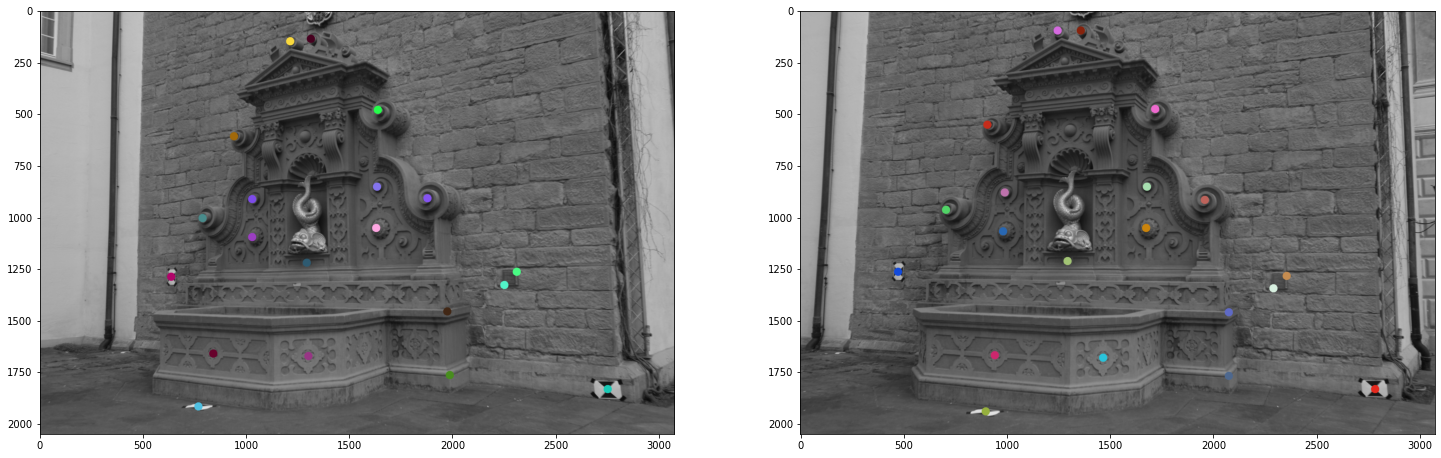

True

In [231]:
image1 = cv2.imread('img1.png', 0)
image2 = cv2.imread('img2.png', 0)
mat = scipy.io.loadmat('points_inliers.mat')
points1 = np.int32(mat['X1'])
points2 = np.int32(mat['X2'])
#F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_LMEDS)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(points2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(image1,image2,lines1,points1,points2, 0)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(image2,image1,lines2,points2,points1, 0)

figure(figsize=(25, 25))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

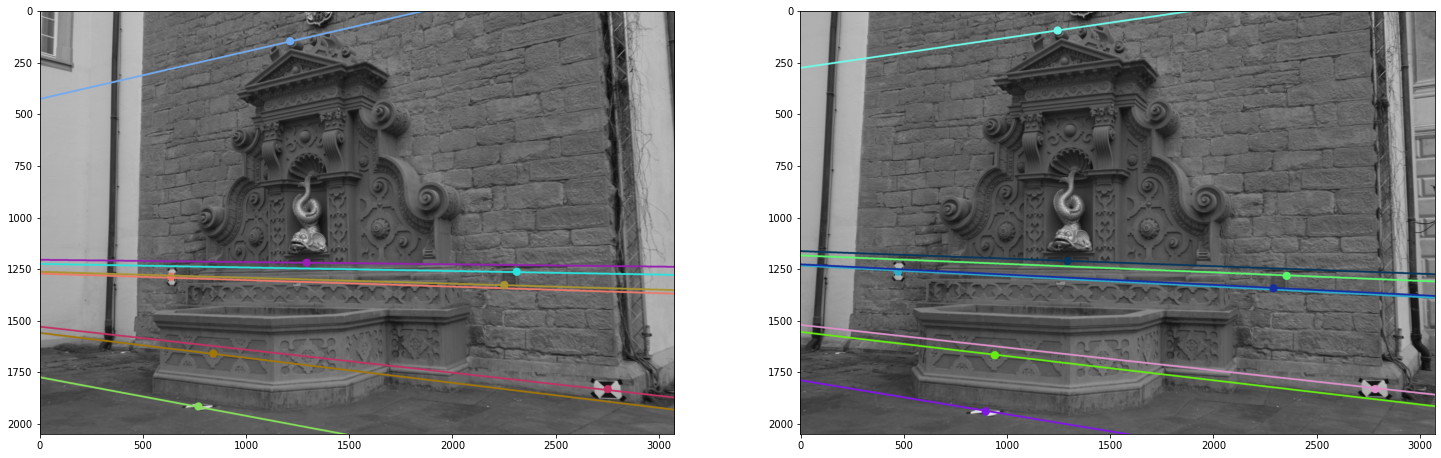

In [240]:
pts2 = np.array([[1246, 94, 1], [2782, 1830, 1], [898, 1938, 1],[474, 1262, 1],   # points of right image in hemegenous coordinates
              [1294, 1210, 1], [2354, 1282, 1], [2290, 1342, 1],[942, 1666, 1]])
pts1 = np.array([[1210,  146, 1], [2746, 1830, 1], [766, 1914, 1],[634, 1286, 1],   # points of left image in hemegenous coordinates
              [1290, 1218, 1], [2306, 1262, 1], [2246, 1326, 1],[838, 1658, 1]])




F = FundamentalMatrix(pts1, pts2) # calculate fundamental matrix implemented in previous section
lines1 = cv2.computeCorrespondEpilines(pts2[:, 0:2].reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(image1,image2,lines1,pts1[:, 0:2],pts2[:, 0:2], 1)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1[:, 0:2].reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(image2,image1,lines2,pts2[:, 0:2],pts1[:, 0:2], 1)

figure(figsize=(25, 25))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [229]:
mat = scipy.io.loadmat('points_inliers.mat')
points1 = np.int32(mat['X1'])
points2 = np.int32(mat['X2'])
print(points1)
print(points2)

[[ 938  606]
 [1634  478]
 [ 786 1002]
 [1874  906]
 [2746 1830]
 [ 634 1286]
 [ 766 1914]
 [1970 1454]
 [2306 1262]
 [1298 1670]
 [ 838 1658]
 [1210  146]
 [1310  134]
 [2246 1326]
 [1026  910]
 [1630  850]
 [1026 1094]
 [1626 1050]
 [1290 1218]
 [1982 1762]]
[[ 906  550]
 [1718  474]
 [ 706  962]
 [1958  914]
 [2782 1830]
 [ 474 1262]
 [ 898 1938]
 [2074 1458]
 [2354 1282]
 [1466 1678]
 [ 942 1666]
 [1246   94]
 [1358   94]
 [2290 1342]
 [ 990  878]
 [1678  850]
 [ 982 1066]
 [1674 1050]
 [1294 1210]
 [2074 1766]]
